## 📦 1️⃣ Download & Extract Dataset and Model

In [ ]:
import os

download_image_url = "https://huggingface.co/evan6007/ResNet_SE_CBAM_KNN/resolve/main/R_image.zip?download=true"
download_weight_url = "https://huggingface.co/evan6007/ResNet_SE_CBAM_KNN/resolve/main/resnet_se_cbam_40_20.pth?download=true"

!wget $download_image_url -O R_image.zip
!wget $download_weight_url -O resnet_se_cbam_40_20.pth
!unzip R_image.zip

--2025-05-07 06:41:33--  https://huggingface.co/evan6007/ResNet_SE_CBAM_KNN/resolve/main/R_image.zip?download=true
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.49, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/0d/a1/0da1f7500b5991cd7222686a95b74d5cc8e1afbd1f9a5e7a7c0f6b0baac4ba3e/b8377c2bea07237188c2c74e411c189abc11a9d091987477084bf517cbc3ead7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27R_image.zip%3B+filename%3D%22R_image.zip%22%3B&response-content-type=application%2Fzip&Expires=1746603693&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjYwMzY5M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzBkL2ExLzBkYTFmNzUwMGI1OTkxY2Q3MjIyNjg2YTk1Yjc0ZDVjYzhlMWFmYmQxZjlhNWU3YTdjMGY2YjBiYWFjNGJhM2UvYjgzNzdjMmJlYTA3MjM3MTg4YzJjNzRlNDExYzE4OWFiYzExYTlkMDkx

## 🛠️ 2️⃣ Import Libraries

In [ ]:
import torch, torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SHAPE = (128, 180)
model_path = '/content/resnet_se_cbam_40_20.pth'
train_folder, test_folder, val_folder = '/content/train_img', '/content/test_img', '/content/val_img'


## 🏗️ 3️⃣ Define Model (Siamese + SE + CBAM)

In [ ]:
class MainBlock(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(MainBlock , self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=(3,3),stride=1),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self,x):
        x = self.main(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels , out_channels ,downsample=None):
        super(ResidualBlock , self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,stride=1,kernel_size=(3,3),bias=False,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,stride=1,kernel_size=(3,3),bias=False,padding=1),
            nn.BatchNorm2d(out_channels),
        )

        self.relu = nn.ReLU()

        self.downsample = downsample

    def forward(self,x):
        identity = x
        x = self.resnet(x)

        if self.downsample is not None:
            identity = self.downsample(x)

        x += identity
        x = self.relu(x)
        return x

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=4):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.global_avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.global_max_pool(x))))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size // 2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, channels, reduction=4, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):

        out = x*self.channel_attention(x)
        out = self.spatial_attention(out)*out
        return out

class SiameseNetwork3(nn.Module):
    def __init__(self):
        super(SiameseNetwork3, self).__init__()

        self.SE = nn.Sequential(
            SEBlock(8),

        )
        self.CBAM = nn.Sequential(
            CBAM(8),

        )

        self.main = nn.Sequential(
            MainBlock(3,8)
        )
        self.Residual = nn.Sequential(
            MainBlock(16,32),
            ResidualBlock(32,32),
            MainBlock(32,64),
            MainBlock(64,64),
        )

        self.linear = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64,16)
        )
    def forward_once(self, x):
        x = self.main(x)
        se_x = self.SE(x)
        cbam_x = self.CBAM(x)
        x = torch.cat((se_x,cbam_x),dim=1)
        x = self.Residual(x)
        x = self.linear(x)

        return x

    def forward(self, input1, input2 , input3):

        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1 , output2 , output3

## 📥 4️⃣ Load Model

In [ ]:
model = SiameseNetwork3().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

SiameseNetwork3(
  (SE): Sequential(
    (0): SEBlock(
      (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Linear(in_features=8, out_features=2, bias=False)
      (relu): ReLU(inplace=True)
      (fc2): Linear(in_features=2, out_features=8, bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (CBAM): Sequential(
    (0): CBAM(
      (channel_attention): ChannelAttention(
        (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
        (global_max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (fc2): Conv2d(2, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (sigmoid): Sigmoid()
      )
      (spatial_attention): SpatialAttention(
        (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (sigmoid): Sigmoid()
      )
    )
  )
  (main): Sequential(
    (0): MainBlock(
      (main): Sequential(
        (0): Co

## 🖼️ 5️⃣ Image Loader

In [ ]:
transform = transforms.Compose([transforms.Resize(INPUT_SHAPE), transforms.ToTensor()])
def read_images(folder):
    images, filenames, labels = [], [], []
    for fn in os.listdir(folder):
        if fn.lower().endswith(('.png','.jpg','.jpeg')):
            img = transform(Image.open(os.path.join(folder,fn)))
            label = 0 if 'pass' in fn else 1 if 'ng' in fn else 0
            images.append(img.numpy()); filenames.append(fn); labels.append(label)
    return np.array(images), np.array(filenames), np.array(labels)

img_train, fname_train, lbl_train = read_images(train_folder)
img_test, fname_test, lbl_test = read_images(test_folder)

t_train = torch.tensor(img_train, dtype=torch.float32).to(device)
t_test = torch.tensor(img_test, dtype=torch.float32).to(device)

## 🧬 6️⃣ Get Features

In [ ]:
with torch.no_grad():
    feat_train, _, _ = model(t_train, t_train, t_train)
    feat_test, _, _ = model(t_test, t_test, t_test)

## 🔬 7️⃣ PCA

In [ ]:
pca = PCA(n_components=3)
X_train_pca, X_test_pca = pca.fit_transform(feat_train.cpu().numpy()), pca.transform(feat_test.cpu().numpy())

## 🏃 8️⃣ KNN Training

In [ ]:
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train_pca), scaler.transform(X_test_pca)
param_grid = {'n_neighbors':[3,4,5], 'weights':['uniform','distance']}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
knn.fit(X_train_scaled, lbl_train)
preds = knn.predict(X_test_scaled)
acc = np.mean(preds == lbl_test)
print(f"KNN Test Accuracy: {acc:.4f}")

KNN Test Accuracy: 0.9000


## 🎨 9️⃣ Visualization

KNN Test Accuracy: 0.9000


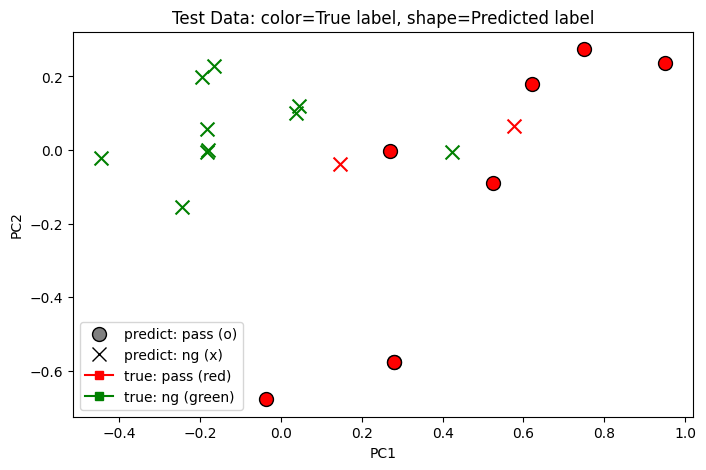

In [ ]:
print(f"KNN Test Accuracy: {acc:.4f}")
colors = ['red' if l==0 else 'green' for l in lbl_test]
markers = ['o' if p==0 else 'x' for p in preds]
plt.figure(figsize=(8,5))
for i in range(len(X_test_pca)):
  edgecolor = 'black' if markers[i] != 'x' else None
  plt.scatter(X_test_pca[i,0], X_test_pca[i,1], color=colors[i], marker=markers[i], s=100, edgecolors=edgecolor)

plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Test Data: color=True label, shape=Predicted label')
legend = [
    plt.Line2D([0], [0], marker='o', color='w', label='predict: pass (o)', markerfacecolor='gray', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='x', color='w', label='predict: ng (x)', markerfacecolor='gray', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='s', color='red', label='true: pass (red)'),
    plt.Line2D([0], [0], marker='s', color='green', label='true: ng (green)')]
plt.legend(handles=legend)
plt.show()